In [1]:
!conda install -y pyarrow s3fs seaborn

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.12
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
sns.set_context('talk')

In [3]:
%%capture
prefix = 's3://danylo-ucla/storage/weather/jobs/transform_batch/20191012-224036_11821011c9a918e8d06e521c8606235e'

train_X = pd.read_parquet(f'{prefix}/train_x.parquet')
train_y = pd.read_parquet(f'{prefix}/train_y.parquet')

validate_X = pd.read_parquet(f'{prefix}/validate_x.parquet')
validate_y = pd.read_parquet(f'{prefix}/validate_y.parquet')

test_X = pd.read_parquet(f'{prefix}/test_x.parquet')
test_y = pd.read_parquet(f'{prefix}/test_y.parquet')

score_X = pd.read_parquet(f'{prefix}/score_x.parquet')

condition_window = 24
prediction_window = 24
features_length = 4

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pyarrow/pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pyarrow/pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [5]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 826464 entries, (Albuquerque/1108/0, 2015-02-16 09:00:00) to (Vancouver/806/12, 2014-07-03 04:00:00)
Data columns (total 4 columns):
humidity       826464 non-null float64
pressure       826464 non-null float64
temperature    826464 non-null float64
wind_speed     826464 non-null float64
dtypes: float64(4)
memory usage: 30.4+ MB


In [6]:
train_X.head()

humidity  pressure  temperature  \
sample             time                                                   
Albuquerque/1108/0 2015-02-16 09:00:00      47.0    1031.0   276.323000   
                   2015-02-16 10:00:00      45.0    1032.0   275.097667   
                   2015-02-16 11:00:00      48.0    1032.0   273.931333   
                   2015-02-16 12:00:00      46.0    1033.0   274.380000   
                   2015-02-16 13:00:00      51.0    1033.0   272.675333   

                                        wind_speed  
sample             time                             
Albuquerque/1108/0 2015-02-16 09:00:00         3.0  
                   2015-02-16 10:00:00         3.0  
                   2015-02-16 11:00:00         2.0  
                   2015-02-16 12:00:00         2.0  
                   2015-02-16 13:00:00         1.0

In [7]:
train_X.groupby('sample').size().head()

sample
Albuquerque/1108/0    24
Albuquerque/1108/1    24
Albuquerque/1108/2    24
Albuquerque/1112/0    24
Albuquerque/1112/1    24
dtype: int64

In [8]:
train_X.loc['Albuquerque/1112/1'].head()

,humidity,pressure,temperature,wind_speed
time,,,,
2015-02-20 18:00:00,46.0,1023.0,282.116500,3.0
2015-02-20 19:00:00,40.0,1021.0,287.061667,4.0
2015-02-20 20:00:00,38.0,1019.0,288.236333,4.0
2015-02-20 21:00:00,35.0,1020.0,286.928000,4.0
2015-02-20 22:00:00,34.0,1017.0,288.930333,5.0


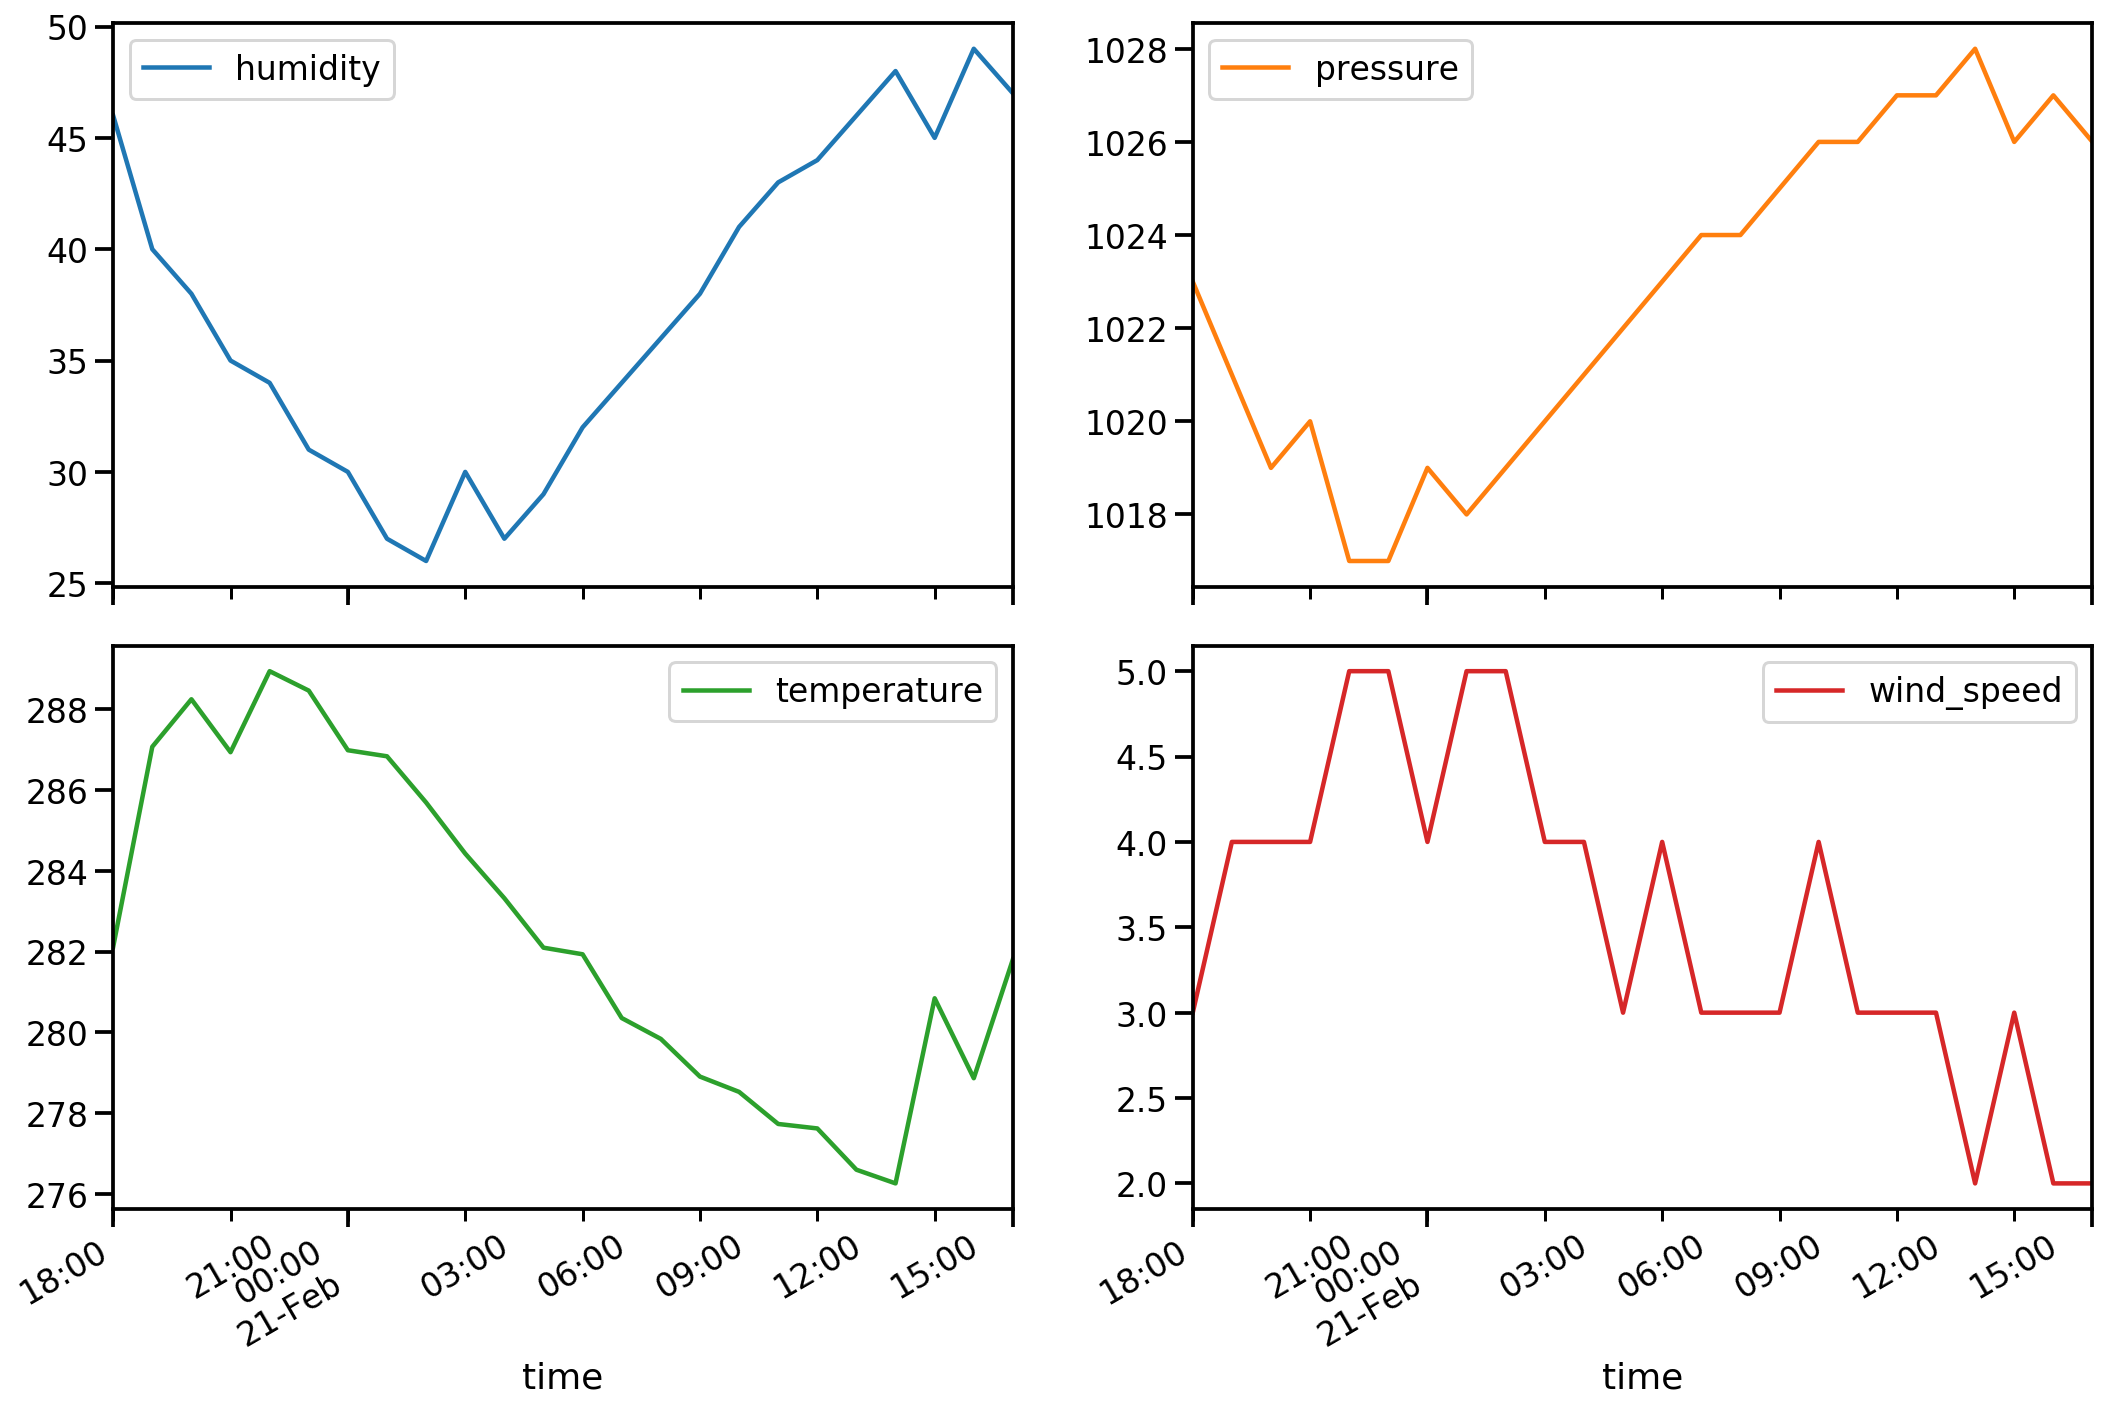

In [9]:
train_X.loc['Albuquerque/1112/1'].plot(subplots=True, layout=(2, 2), figsize=[15, 10])
plt.tight_layout()

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_X)

scaled_X = {
    'train': scaler.transform(train_X),
    'validate': scaler.transform(validate_X),
    'test': scaler.transform(test_X),
    'score': scaler.transform(score_X),
}

In [76]:
# Keras RNN cells expect inputs with 3 dimensions:
# (batch_size, condition_window, features_length)
# Each RNN cell takes a vector of features_length
# at each time step of condition_window.
# Internal RNN cell state is reset between different batch samples.

# Let's review current shapes of the input, and the desired shapes.

def expected_X_shape(actual_X_shape):
    return (int(actual_X_shape[0]/condition_window), condition_window, features_length)

def expected_y_shape(actual_y_shape):
    return (int(actual_y_shape[0]/prediction_window), prediction_window)


pd.DataFrame({
    'actual shape': [
        train_X.shape, 
        train_y.shape,
    ],
    'expected shape': [
        expected_X_shape(train_X.shape), 
        expected_y_shape(train_y.shape), 
    ],
}, index=['train_X', 'train_y'])

,actual shape,expected shape
train_X,"(826464, 4)","(34436, 24, 4)"
train_y,"(826464, 4)","(34436, 24)"


In [13]:
# Exepected shape can be achieved with a simple reshape call.
# Note that these are not Pandas data frames any more,
# but Numpy n-dimensional arrays.
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html

def frame_to_ndarray(frame_X, frame_y):
    X_nd = frame_X.reshape(-1, condition_window, features_length).astype('float32')
    y_nd = frame_y['temperature'].values.reshape(-1, prediction_window).astype('float32')
    return X_nd, y_nd

train_X_nd, train_y_nd = frame_to_ndarray(scaled_X['train'], train_y)
validate_X_nd, validate_y_nd = frame_to_ndarray(scaled_X['validate'], validate_y)

# Task: Transform other segments of the dataset (test, and score).
# Enter your code here.

In [14]:
# Let's confirm the expected shape.

pd.DataFrame({
    'actual shape': [
        train_X_nd.shape, 
        train_y_nd.shape,
        validate_X_nd.shape,
        validate_y_nd.shape,
    ],
    'expected shape': [
        expected_X_shape(train_X.shape), 
        expected_y_shape(train_y.shape), 
        expected_X_shape(validate_X.shape), 
        expected_y_shape(validate_y.shape), 
    ]},
    index=['train_X', 'train_y', 'validate_X', 'validate_y']
)

,actual shape,expected shape
train_X,"(34436, 24, 4)","(34436, 24, 4)"
train_y,"(34436, 24)","(34436, 24)"
validate_X,"(2288, 24, 4)","(2288, 24, 4)"
validate_y,"(2288, 24)","(2288, 24)"


In [15]:
from tensorflow.python.keras.layers import Dense, CuDNNGRU, BatchNormalization
from tensorflow.python.keras.models import Sequential
from tensorflow.python import GlorotUniform

layers = [
        CuDNNGRU(
            input_shape=(condition_window, features_length),
            units=100,
            return_sequences=True,
            kernel_initializer=GlorotUniform(seed=42)
        ),
        BatchNormalization(),
        CuDNNGRU(
            units=50,
            return_sequences=True,
            kernel_initializer=GlorotUniform(seed=42)
        ),
        BatchNormalization(),
        CuDNNGRU(
            units=25,
            return_sequences=False,
            kernel_initializer=GlorotUniform(seed=42)
        ),
        BatchNormalization(),
        Dense(
            units=prediction_window,
            activation='linear'
        )
]

model = Sequential(layers)

W1013 00:53:42.945338 139907569325888 deprecation.py:506] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru (CuDNNGRU)         (None, 24, 100)           31800     
_________________________________________________________________
batch_normalization (BatchNo (None, 24, 100)           400       
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (None, 24, 50)            22800     
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 50)            200       
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, 25)                5775      
_________________________________________________________________
batch_normalization_2 (Batch (None, 25)                100       
_________________________________________________________________
dense (Dense)                (None, 24)                6

In [26]:
from utils import r2_score, mean_error
from tensorflow.python.keras.optimizers import Adam

model.compile(
    optimizer=Adam(lr=0.01),
    loss='mean_squared_error',
    metrics=[
        'mean_absolute_error',
        r2_score,
        mean_error
    ]
)

In [20]:
from tensorflow.python.keras.callbacks import TerminateOnNaN, ReduceLROnPlateau, EarlyStopping

history = model.fit(
    train_X_nd,
    train_y_nd,
    validation_data=[validate_X_nd, validate_y_nd],
    epochs=20,
    batch_size=100,
    callbacks=[
        TerminateOnNaN(),
        ReduceLROnPlateau(
            monitor='loss',
            min_delta=0.1,
            patience=5,
            cooldown=10,
            verbose=1
        ),
        EarlyStopping(
            monitor='loss',
            min_delta=0.1,
            patience=10
        )
    ]
)

Train on 34436 samples, validate on 2288 samples
Epoch 1/20
34436/34436 [==============================] - 12s 355us/sample - loss: 32105.0630 - mean_absolute_error: 144.8859 - r2_score: -236.9466 - mean_error: -144.5234 - val_loss: 26.5237 - val_mean_absolute_error: 3.9998 - val_r2_score: 0.6943 - val_mean_error: -1.0105
Epoch 2/20
34436/34436 [==============================] - 10s 301us/sample - loss: 22.9042 - mean_absolute_error: 3.7773 - r2_score: 0.8294 - mean_error: -0.1657 - val_loss: 23.1584 - val_mean_absolute_error: 3.7276 - val_r2_score: 0.7326 - val_mean_error: 0.3072
Epoch 3/20
34436/34436 [==============================] - 10s 302us/sample - loss: 20.8105 - mean_absolute_error: 3.5901 - r2_score: 0.8451 - mean_error: -0.0248 - val_loss: 24.7004 - val_mean_absolute_error: 3.7980 - val_r2_score: 0.7161 - val_mean_error: -0.7946
Epoch 4/20
34436/34436 [==============================] - 10s 301us/sample - loss: 18.4823 - mean_absolute_error: 3.3628 - r2_score: 0.8621 - mean_

In [61]:
# Note that Keras evaluates metrics in batches,
# which is okay for averaging-stable metrics like ME, MSE, and MAE,
# but R2 requires full dataset to evaluate precisely.

# This implies two things:
# 1) R2 as reported during training is not precise
# 2) when evaluating R2 after training, batch size must match dataset size

nd_array_by_segment = {
    'train': (train_X_nd, train_y_nd),
    'validate': (validate_X_nd, validate_y_nd)
}

metrics_by_segment = {
    segment: model.evaluate(
        X_nd, 
        y_nd, 
        verbose=0, 
        batch_size=X_nd.shape[0]
    )
    for segment, (X_nd, y_nd) in nd_array_by_segment.items()
}

rnn_metrics = pd.concat([
    pd.DataFrame(
        data=[metrics], 
        columns=['MSE', 'MAE', 'R2', 'ME'], 
        index=[segment]
    )
    for segment, metrics in metrics_by_segment.items()
])

rnn_metrics = pd.DataFrame([rnn_metrics.unstack()], index=['rnn'])\
    .swaplevel(axis=1, i=0, j=1)\
    .reindex(nd_array_by_segment.keys(), axis=1, level=0)\
    .round(2)

rnn_metrics

train                   validate                  
      MSE   MAE    R2    ME      MSE   MAE    R2    ME
rnn   5.9  1.83  0.96  0.09    20.56  3.39  0.77  0.33

In [73]:
%%capture

from utils import SegmentDataset, baseline_metrics

segment_names = ['train', 'validate']
panel_dataset = SegmentDataset.from_pq_workdir(prefix, segment_names, ['x', 'y'])
baseline_metrics = baseline_metrics(panel_dataset)

In [75]:
pd.concat([
    baseline_metrics,
    rnn_metrics
], axis=0).loc[:, (slice(None), ['MSE', 'R2'])].round(2)

train       validate      
              MSE    R2      MSE    R2
mean        26.77  0.80    37.23  0.58
constant    21.82  0.84    40.25  0.54
regression  30.53  0.78    29.94  0.66
rnn          5.90  0.96    20.56  0.77

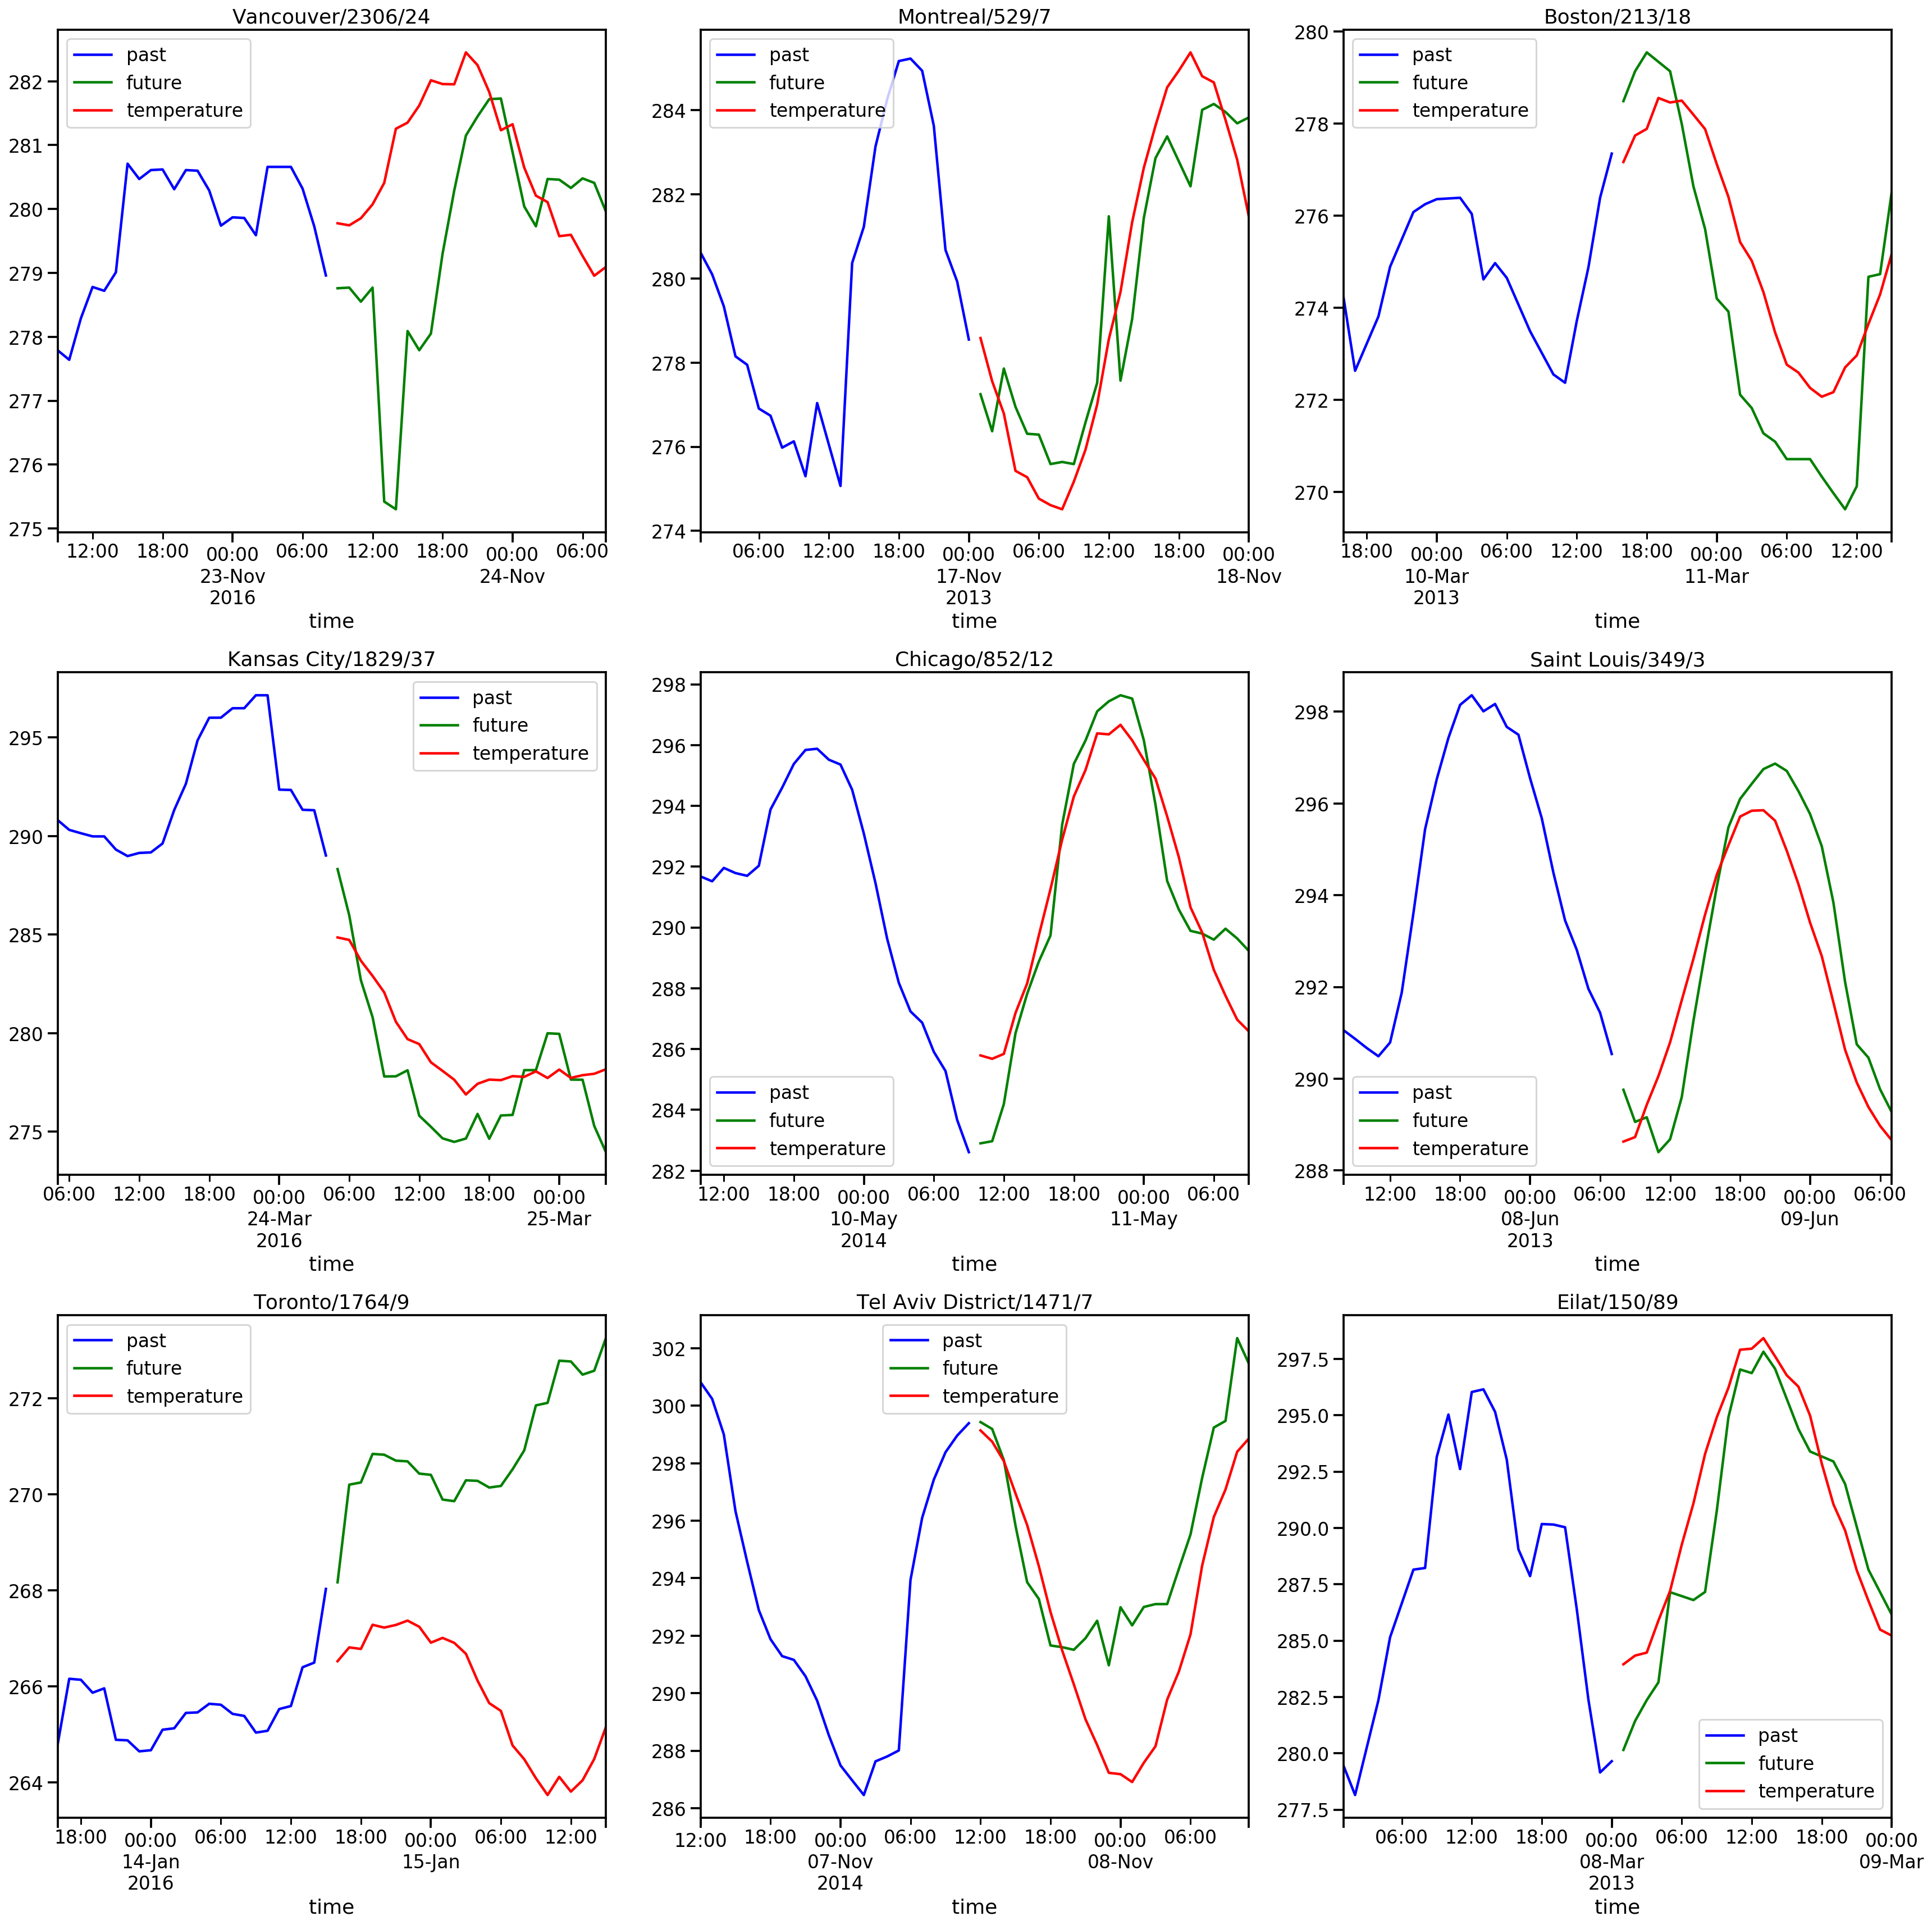

In [66]:
from utils import nd_target_like_panel, plot_random_forecasts

train_y_hat = nd_target_like_panel(train_y, model.predict(train_X_nd))

plot_random_forecasts(
    train_X['temperature'],
    train_y['temperature'],
    train_y_hat
)